# TEST

In [15]:
from libraries import * # Import libraries from libraries.py
from import_data import * # Import data from import_data.py
from global_variables import * # Import global variables from global_variables.py
from plotting_functions import * # Import plotting functions from plotting_functions.py

df_joined_cases = pd.read_csv(os.getcwd().split('API-201Z')[0] + 'API-201Z/Data Sources/cleaned_joined_states.csv')


testing testing one two three

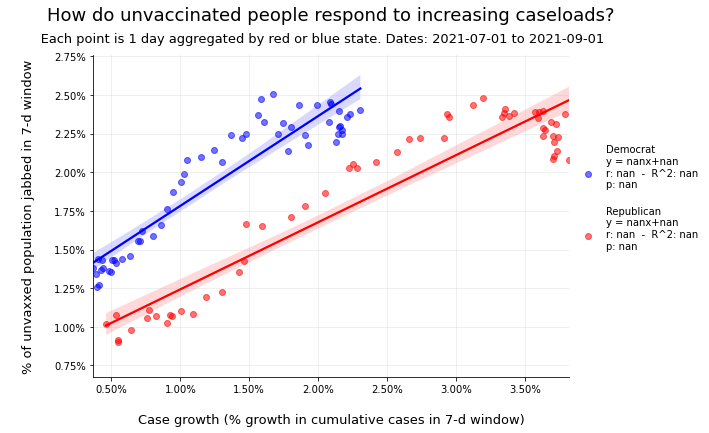

In [16]:
agg_lm(
    data=df_joined_cases,
    groupby='2020 Election Winner',
    hue_levels={'Democrat':'blue', 'Republican':'red'},
    suptitle='Each point is 1 day aggregated by red or blue state',
    start="2021-07-01",
    end="2021-09-01"
)


In [17]:
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data)
df.columns = ['Age', 'Sex', 'BMI', 'ABP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
df['target'] = diabetes.target

est = sm.OLS(endog=df['target'], exog=sm.add_constant(df[df.columns[0:4]])).fit()
est2 = sm.OLS(endog=df['target'], exog=sm.add_constant(df[df.columns[0:6]])).fit()

stargazer = Stargazer([est, est2])

stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{2}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{2-3}\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n ABP & 416.674$^{***}$ & 397.583$^{***}$ \\\\\n  & (69.495) & (70.870) \\\\\n Age & 37.241$^{}$ & 24.704$^{}$ \\\\\n  & (64.117) & (65.411) \\\\\n BMI & 787.179$^{***}$ & 789.742$^{***}$ \\\\\n  & (65.424) & (66.887) \\\\\n S1 & & 197.852$^{}$ \\\\\n  & & (143.812) \\\\\n S2 & & -169.251$^{}$ \\\\\n  & & (142.744) \\\\\n Sex & -106.578$^{*}$ & -82.862$^{}$ \\\\\n  & (62.125) & (64.851) \\\\\n const & 152.133$^{***}$ & 152.133$^{***}$ \\\\\n  & (2.853) & (2.853) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 442 & 442 \\\\\n $R^2$ & 0.400 & 0.403 \\\\\n Adjusted $R^2$ & 0.395 & 0.395 \\\\\n Residual Std. Error & 59.976(df = 437) & 59.982(df = 435)  \\\\\n F Statistic & 72.913$^{***}$ (df = 4.0; 437.0) & 48.915$^{***}$ (df = 6.0; 435.0) \\\\\n